In [1]:
%%capture
!pip install dowhy==0.6

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import dowhy
import dowhy.api
import dowhy.datasets
import dowhy.plotter

# Causal Inference with DoWhy

By Alessio Zanga and Fabio Stella

## Abstract

This notebook represents a quick-start guide to causal inference using the [DoWhy](https://github.com/microsoft/dowhy) package.

## Generate a Dataset

DoWhy allows the generation of a dataset by specifying a set of parameters.

In [4]:
dataset = dowhy.datasets.linear_dataset(
    beta = 1,
    num_samples = int(1e4),
    num_common_causes = 1,
    num_frontdoor_variables = 1,
    treatment_is_binary = True,
    outcome_is_binary = True
)

list(dataset.keys())

['df',
 'treatment_name',
 'outcome_name',
 'common_causes_names',
 'instrument_names',
 'effect_modifier_names',
 'frontdoor_variables_names',
 'dot_graph',
 'gml_graph',
 'ate']

It will return a dictionary with a Pandas DataFrame, along with a set of variables names and the true causal graph used for the sampling process.

In [5]:
data, [treatment], outcome, _, _, _, _, _, causal_graph, ace = dataset.values()

After unpacking the values of the dictionary, it is possible to observe the assigned names to the data columns:

In [6]:
treatment, outcome

('v0', 'y')

It also return the true average causal effect:

In [7]:
ace

In [8]:
data

,FD0,W0,v0,y
0,-1.229433,1.490153,False,False
1,0.376174,2.414687,True,False
2,0.578884,0.553060,True,True
3,-0.690915,0.474165,True,True
4,0.408051,-0.049500,False,True
...,...,...,...,...
9995,1.836035,2.554652,False,True
9996,1.790884,1.015481,False,True
9997,-1.242127,0.292431,True,False
9998,0.977336,0.670689,True,True


## Construct a Model

The second step consists in constructing a causal model using the true graph.

In [9]:
model = dowhy.CausalModel(
    data = data,
    treatment = treatment,
    outcome = outcome,
    graph = causal_graph
)

It is not a proper SCM as we seen in previous sessions. It is more like a container for the data and the graph.

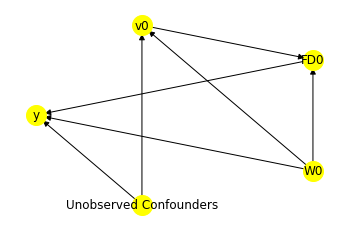

In [10]:
model.view_model(layout="dot")
# from IPython.display import Image, display    # Run these lines if you are on local.
# display(Image(filename="causal_model.png"))

This will enable the identification step by using a couple of handful methods.

## Identify the Estimand

The estimand identification tests for both backdoor and frontdoor criterion.

In [11]:
estimand = model.identify_effect(proceed_when_unidentifiable=True)

print(estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                     
─────(Expectation(y|W0))
d[v₀]                   
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,U) = P(y|v0,W0)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
Estimand expression:
Expectation(Derivative(y, [FD0])*Derivative([FD0], [v0]))
Estimand assumption 1, Full-mediation: FD0 intercepts (blocks) all directed paths from v0 to y.
Estimand assumption 2, First-stage-unconfoundedness: If U→{v0} and U→{FD0} then P(FD0|v0,U) = P(FD0|v0)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{FD0} and U→y then P(y|FD0, v0, U) = P(y|FD0, v0)



## Estimate the Average Causal Effect

Once the estimand has been identified, we can proceed to the last estimation step.

In [12]:
estimators = [
    "backdoor.linear_regression",
    "backdoor.propensity_score_stratification",
    "backdoor.propensity_score_weighting",
    "backdoor.propensity_score_matching",
]

We will iterate over the provided methods and compare the results.

In [13]:
estimates = {
    estimator: model.estimate_effect(estimand, method_name=estimator)
    for estimator in estimators
}

In [14]:
for estimate in estimates.values():
    print(estimate)
    break

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                     
─────(Expectation(y|W0))
d[v₀]                   
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,U) = P(y|v0,W0)

## Realized estimand
b: y~v0+W0
Target units: ate

## Estimate
Mean value: 0.03435719140200377



In [15]:
for estimator, estimate in estimates.items():
    print(f"""
    Estimator: {estimator},
    Estimate: {estimate.value:.4},
    Relative Error: {(abs((estimate.value-ace)/ace*100)):.4}%
    """.lstrip("\n"))

    Estimator: backdoor.linear_regression,
    Estimate: 0.03436,
    Relative Error: 35.78%
    
    Estimator: backdoor.propensity_score_stratification,
    Estimate: 0.03479,
    Relative Error: 34.97%
    
    Estimator: backdoor.propensity_score_weighting,
    Estimate: 0.03436,
    Relative Error: 35.78%
    
    Estimator: backdoor.propensity_score_matching,
    Estimate: 0.0446,
    Relative Error: 16.64%
    


## Evaluate the Results

With the estimates obtained we can setup a round of hypothesis testing.

In [16]:
refuters = [
    "bootstrap_refuter",
    "data_subset_refuter",
    "dummy_outcome_refuter",
    "placebo_treatment_refuter",
    "random_common_cause",
]

We will take the backdoor with linear regression as estimate of reference.

In [17]:
refuteds = {
    refuter: model.refute_estimate(
      estimand,
      estimates["backdoor.linear_regression"],
      method_name=refuter
    )
    for refuter in refuters
}

Some "refuters", as they are called in DoWhy, may return a list of tests.

In [18]:
for refuter in refuteds.values():
    print(refuter if type(refuter) != list else refuter[0])

Refute: Bootstrap Sample Dataset
Estimated effect:0.03435719140200377
New effect:0.03433061361432344
p value:0.43999999999999995

Refute: Use a subset of data
Estimated effect:0.03435719140200377
New effect:0.03516756158619447
p value:0.47

Refute: Use a Dummy Outcome
Estimated effect:0
New effect:0.005771850986676498
p value:0.38

Refute: Use a Placebo Treatment
Estimated effect:0.03435719140200377
New effect:0.0006015473612568245
p value:0.49

Refute: Add a Random Common Cause
Estimated effect:0.03435719140200377
New effect:0.034442581051901566



Your results may vary. Try to experiment with different graph configurations by altering the numbers of variables in the generation step.

Have fun!